In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), 'temp','py-causal','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print l
    javabridge.JARS.append(str(l))

/home/jovyan/work/temp/py-causal/src/pycausal/lib/tetrad-lib-5.3.0-SNAPSHOT-tetradcmd.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), 'temp','py-causal','data', 'charity.txt')
data_dir

'/home/jovyan/work/temp/py-causal/data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1,0,7,4,4.5
1,1,0,2,2,2.0
2,1,0,7,3,3.0
3,1,0,4,3,4.5
4,1,0,3,7,1.0


In [6]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [7]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [8]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.make_instance("java/lang/Double", "(D)V", dframe.ix[row][col])
        dataBox.set(row,col,value)

In [9]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [10]:
tetradData = javabridge.JClassWrapper("edu.cmu.tetrad.data.CovarianceMatrixOnTheFly")(boxData)

In [11]:
score = javabridge.JClassWrapper("edu.cmu.tetrad.search.SemBicScore")(tetradData)
score.setPenaltyDiscount(2)# set to 2 if variable# <= 50 otherwise set it to 4

In [12]:
fgs = javabridge.JClassWrapper("edu.cmu.tetrad.search.Fgs")(score)

In [13]:
fgs.setDepth(-1)
fgs.setNumPatternsToStore(0)
fgs.setHeuristicSpeedup(True)
fgs.setParallelism(2)
fgs.setVerbose(True)

In [14]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'TangibilityCondition')
prior.addToTier(0, 'Imaginability')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(2, 'Impact')
fgs.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

0* Imaginability TangibilityCondition 
1 AmountDonated Sympathy 
2 Impact 

forbiddirect

TangibilityCondition ==> Impact 
requiredirect

Sympathy ==> TangibilityCondition 

In [15]:
tetradGraph = fgs.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact

Graph Edges:
1. Sympathy --> TangibilityCondition

In [16]:
tetradGraph.toString()

u'Graph Nodes:\nTangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact\n\nGraph Edges:\n1. Sympathy --> TangibilityCondition'

In [17]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [TangibilityCondition, AmountDonated, Sympathy, Imaginability, Impact]

In [18]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [Sympathy --> TangibilityCondition]

In [19]:
graph = pydot.Dot(graph_type='digraph')

In [20]:
n = tetradGraph.getNodeNames().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
for i in range(0,len(n)):
    node = n[i]
    n[i] = node.strip()
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

In [21]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print "Node %s does not exist!", node
        return False

e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) == 3):
        src = token[0]
        arc = token[1]
        dst = token[2]
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            if(arc == "---"):
                edge.set_arrowhead("none")
            graph.add_edge(edge)

In [22]:
svg_str = graph.create_svg(prog='dot')

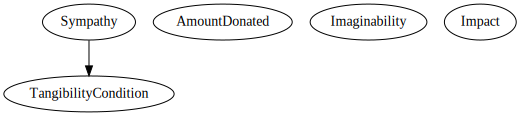

In [23]:
SVG(svg_str)

In [28]:
javabridge.detach()
javabridge.kill_vm()